In [1]:

# Import the relevant modules
from __future__ import print_function # Use a function definition from future version (say 3.x from 2.7 interpreter)
import matplotlib.pyplot as plt
import numpy as np
import os
import sys

# Import CNTK
import cntk as C


import cntk.io.transforms as xforms
import cntk.tests.test_utils
#C.cntk_py.set_fixed_random_seed(1) # fix a random seed for CNTK components

try:
    from urllib.request import urlretrieve
except ImportError:
    from urllib import urlretrieve
    
import gzip
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import shutil
import struct
import sys
    
import glob
import socket
%matplotlib inline


In [2]:
if socket.gethostname() == 'dsvm':
    root = r'/home/kumaran/Data'
else:
    root = r'E:\Temp\\'
    
data_dir = os.path.join(root, 'lfw')
#data_dir = os.path.join(root, 'MNIST')
# down data from http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
# model dimensions
img_h = 36
img_w  = 36

num_channels = 3
input_dim = (num_channels, img_h, img_w)
num_classes  = 2
latent_dim = 15

e_kernel_1 = (3,3)
e_stride_1 = (2,2)
e_filter_1 = 16
e_filter_2 =  32

isFast = False
epoch_size = 30000        # 30000 samples is half the dataset size
minibatch_size = 64
num_sweeps_to_train_with = 10 if isFast else 500
num_samples_per_sweep = 60000
num_minibatches_to_train = (num_samples_per_sweep * num_sweeps_to_train_with) // minibatch_size
num_samples_to_test = 10000

#map_file = os.path.join(data_dir, 'cntk_image_data.tsv')

In [3]:
def create_reader_lfw(map_file, is_training):
    print("Reading map file:", map_file)    

    if not os.path.exists(map_file):
        raise RuntimeError("This tutorials depends 201A tutorials, please run 201A first.")

    # transformation pipeline for the features has jitter/crop only when training
    transforms = []
    # train uses data augmentation (translation only)
    if is_training and False:
        transforms += [
            xforms.crop(crop_type='randomside', side_ratio=0.8)
        ]
    transforms += [
        xforms.scale(width=img_w, height=img_w, channels=num_channels, interpolations='linear')        
    ]    
    
    # deserializer
    return C.io.MinibatchSource(C.io.ImageDeserializer(map_file, C.io.StreamDefs(
        input = C.io.StreamDef(field='image', transforms=transforms), # first column in map file is referred to as 'image'
        labels   = C.io.StreamDef(field='label', shape=num_classes)      # and second as 'label'
    )), randomize = is_training, max_sweeps = C.io.INFINITELY_REPEAT if is_training else 1)

In [21]:
import math
import cv2
def gridPlot(images):
    n = images.shape[0]
    c = 10
    r = math.ceil(n/c)
    fig, axes = plt.subplots(nrows=r, ncols=c, figsize=(50, 50))
    print(axes)
    
    for i in range(n):
        axes[i].imshow(np.asarray(images[i][0].transpose(1,2,0))/255.0)
        #axes[i].imshow(np.asarray(images[i][0].transpose(1,2,0), dtype=np.int32))

In [20]:
reader = create_reader_lfw(os.path.join(data_dir, 'lfw_map.tsv'), True)

map = {'input': reader.streams.input, 'label': reader.streams.labels}
data = reader.next_minibatch(10, input_map=map)

data['input'].shape

Reading map file: /home/kumaran/Data/lfw/lfw_map.tsv


(10, 1, 3, 36, 36)

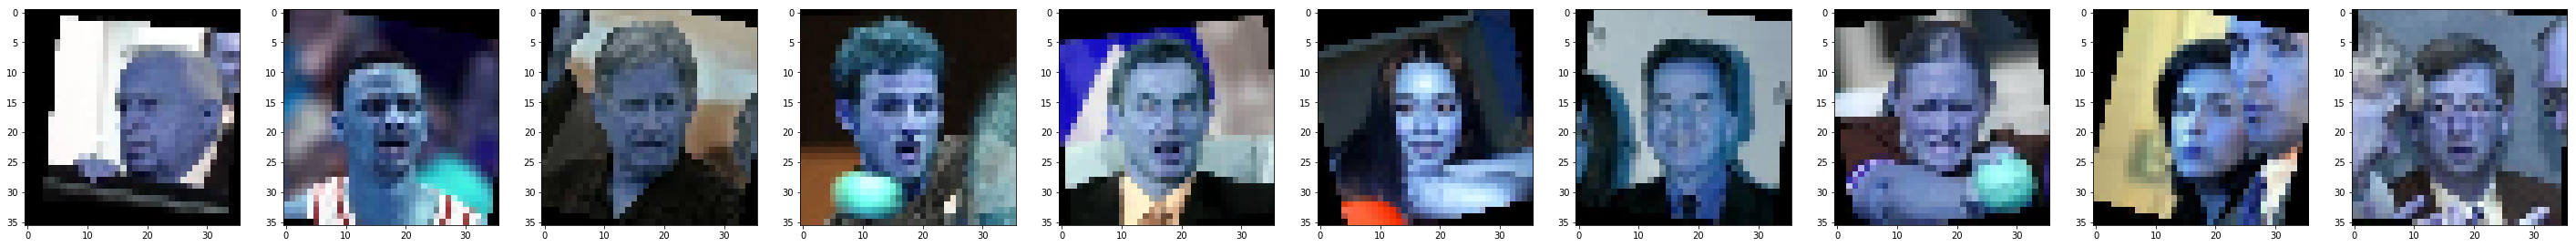

In [14]:
gridPlot(data['input'].data.asarray())

In [5]:
def encoder_cnn(input):    
    with C.layers.default_options(init=C.normal(scale=0.02)):

        print('Discriminator convolution input shape', input.shape)
        print(e_kernel_1)
        h0 = C.layers.Convolution2D(e_kernel_1, e_filter_1, strides=e_stride_1, pad=True, activation=C.relu)(input)
        print('h0 shape :', h0.shape)
                
        h1 = C.layers.Convolution2D(e_kernel_1, e_filter_2, strides=e_stride_1, pad=True, activation=C.relu)(h0)        
        print('h1 shape :', h1.shape)
        
        
        mu = C.layers.Dense(latent_dim, activation=None)(h1)        
        print('mu shape :', mu.shape)
        
        sig = C.layers.Dense(latent_dim, activation=C.relu, init=C.normal(scale=1))(h1)
        print('sig shape :', sig.shape)

        return mu, sig
    
def decoder_cnn(z):
    with C.layers.default_options(init=C.normal(scale=0.02)):
        
        
        print('Generator input shape: ', z.shape)
        s_h2, s_w2 = img_h//2, img_w//2 #Input shape (14,14)
        s_h4, s_w4 = img_h//4, img_w//4 # Input shape (7,7)
        
        h1 = C.layers.Dense([e_filter_2, s_h4,  s_w4], activation=C.relu)(z)        
        print('h1 shape', h1.shape)

        h2 = C.layers.ConvolutionTranspose2D(e_kernel_1, num_filters=e_filter_1, strides=e_stride_1, pad=True, output_shape=(s_h2, s_w2), activation=C.relu)(h1)        
        print('h2 shape', h2.shape)

        h3 = C.layers.ConvolutionTranspose2D(e_kernel_1, num_filters=num_channels, strides=e_stride_1, pad=True, output_shape=(img_h, img_w), activation=C.sigmoid)(h2)
        print('h3 shape :', h3.shape)
        

        return h3

def decoder(input):
    return decoder_cnn(input)
    
def encoder(input):
    return encoder_cnn(input)
network = {}


def create_network():
    input = C.input_variable((num_channels,img_w, img_h))
    label = C.input_variable(input_dim)
    network['input'] = input
    network['label'] = label

    # Create the model function
    mu, sig = encoder(input/255.0)
    
    
    z = C.random.normal_like(mu, mean=0, scale=1)
    z = mu + z * sig
    network['mu'] = mu
    network['sig'] = sig
    
    z_placeholder = C.placeholder()            
    output = C.as_block(decoder(z_placeholder), [(z_placeholder, z)], 'Decoder', 'Decoder_1')    
    #output = decoder(z)
    network['output'] = output
    target = input/255.0
    construction_loss = C.losses.squared_error(target, output)
    
    
    #l1 = C.element_times(target, C.log(output))
    #l2 = C.element_times(1.0-target, C.log(1.0-output))
    #print(l1.shape)
    #print(l2.shape)
                         
    #construction_loss = C.reduce_sum(-1 * C.plus(l1, l2))
    #print(construction_loss.shape)
    
    #construction_loss = C.reduce_sum(C.binary_cross_entropy(output, target))                         
    
    log_stddev = C.log(sig)
    kl_loss = - 0.5 * C.reduce_sum((1 + C.log(C.square(sig)) - C.square(mu) - C.square(C.exp(log_stddev))))
    loss = 0.5 * construction_loss + 0.5 * kl_loss
    
    error  = construction_loss
    network['loss'] = loss
    network['error'] = error
    return network



In [6]:
def train(train_file, test_file):
    create_network()
    
    loss = network['loss']
    output = network['output']
    error = network['error']
    input = network['input']
    label = network['label']
    
     # Instantiate the trainer object to drive the model training
    lr_per_sample = [0.00008]
    lr_schedule = C.learning_parameter_schedule_per_sample(lr_per_sample, epoch_size)
    # Momentum which is applied on every minibatch_size = 64 samples
    momentum_schedule = C.momentum_schedule(0.9126265014311797, minibatch_size)
    # We use a variant of the Adam optimizer which is known to work well on this dataset
    # Feel free to try other optimizers from
    # https://www.cntk.ai/pythondocs/cntk.learner.html#module-cntk.learner
    learner = C.fsadagrad(output.parameters,
                         lr=lr_schedule, momentum=momentum_schedule)
    
    #learner = C.adam(output.parameters, lr=lr_schedule, momentum=momentum_schedule)

    # Instantiate the trainer
    progress_printer = C.logging.ProgressPrinter(0)
    trainer = C.Trainer(output, (loss, error), learner, progress_printer)

    # Map the data streams to the input and labels.
    # Note: for autoencoders input == label
    input_map = {
        input  : train_file.streams.input,
        label  : train_file.streams.labels
    }
    
    test_input_map = {
        input  : test_file.streams.input,
        label  : test_file.streams.labels
    }
    aggregate_metric = 0
    for i in range(num_minibatches_to_train):
        # Read a mini batch from the training data file
        data = train_file.next_minibatch(minibatch_size, input_map = input_map)

        # Run the trainer on and perform model training
        trainer.train_minibatch(data)
        samples = trainer.previous_minibatch_sample_count
        aggregate_metric += trainer.previous_minibatch_evaluation_average * samples

    train_error = (aggregate_metric*100.0) / (trainer.total_number_of_samples_seen)
    print("Average training error: {0:0.2f}%".format(train_error))
    
    metric_numer = 0.0
    metric_denom = 0
    while True:        
        data = test_file.next_minibatch(minibatch_size,
                                       input_map = test_input_map)
        n = minibatch_size
        eval_error = trainer.test_minibatch(data)
        metric_numer += np.abs(eval_error * n)
        metric_denom += n
        if metric_denom > num_samples_to_test:
            break
    # Average of evaluation errors of all test minibatches
    test_error = (metric_numer*100.0) / (metric_denom)
    print("Average test error: {0:0.2f}%".format(test_error))

    
    

train_file = create_reader_lfw(os.path.join(data_dir, 'lfw_map.tsv'), True)
test_file = create_reader_lfw(os.path.join(data_dir, 'lfw_map.tsv'), False)

train(train_file, test_file)

Reading map file: /home/kumaran/Data/lfw/lfw_map.tsv
Reading map file: /home/kumaran/Data/lfw/lfw_map.tsv
Discriminator convolution input shape (3, 36, 36)
(3, 3)
h0 shape : (16, 18, 18)
h1 shape : (32, 9, 9)
mu shape : (15,)
sig shape : (15,)
Generator input shape:  (-2,)
h1 shape (-2,)
h2 shape (-2,)
h3 shape : (-2,)
 average      since    average      since      examples
    loss       last     metric       last              
 ------------------------------------------------------


/anaconda/envs/py35/lib/python3.5/site-packages/cntk/learners/__init__.py:340: RuntimeWarning: When providing the schedule as a number, epoch_size is ignored
  warnings.warn('When providing the schedule as a number, epoch_size is ignored', RuntimeWarning)


Learning rate per 1 samples: 8e-05
      395        395        369        369            64
      402        406        390        401           192
      384        369        383        377           448
      348        316        384        384           960
      296        247        380        377          1984
      249        204        369        358          4032
      212        177        339        310          8128
      187        161        307        274         16320
      168        150        280        253         32704
      150        132        248        216         65472
      146        142        229        211        131008
      133        120        204        179        262080
      121        108        181        158        524224
      119        116        170        160       1048512
      113        107        159        148       2097088
      108        104        153        147       4194240
     99.6       91.1        137        122       8388

In [26]:
test = create_reader_lfw(os.path.join(data_dir, 'lfw_map.tsv'), False)
input_map = {
        network['input']  : test.streams.input,
        network['label']  : test.streams.labels
    }
data = test.next_minibatch(minibatch_size, input_map=input_map)
output = network['output'].eval(data)

Reading map file: /home/kumaran/Data/lfw/lfw_map.tsv


In [46]:
output[0].shape

(3, 36, 36)

In [31]:
import math
import cv2
def gridPlot(images):
    n = images.shape[0]
    c = 10
    r = math.ceil(n/c)
    fig, axes = plt.subplots(nrows=r, ncols=c, figsize=(50, 50))
    
    for i in range(n):
        axes[i].imshow(np.asarray(images[i][0].transpose(1,2,0))/255.0)
        #axes[i].imshow(np.asarray(images[i][0].transpose(1,2,0), dtype=np.int32))

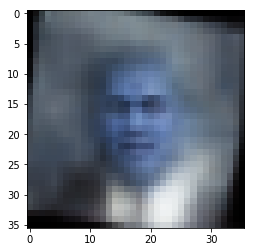

In [55]:
plt.imshow(output[8].transpose(1,2,0))

In [56]:
d = network['output'].find_by_name('Decoder_1')


x = d.clone('freeze', {d.arguments[0] : C.input_variable(latent_dim)})

In [63]:
idx = np.random.choice(minibatch_size)
C.cntk_py.set_fixed_random_seed(idx)
random = C.random.normal((latent_dim), mean=0, scale=1)
x.eval(random.eval()).shape



(1, 3, 36, 36)

In [208]:

x.eval(C.random.normal((32), mean=0, scale=1).eval()).shape

(1, 784)